In [1]:
# mount google drive to access data
from google.colab import drive
drive.mount('/content/gdrive')

# go to project folder
%cd gdrive/My Drive/Colab Notebooks/lego-sandpit/

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/lego-sandpit


In [2]:
# libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
from torch import nn # 'object-oriented'
from torch.nn import functional as F # 'functions'
from torch.utils.data import DataLoader, Sampler
from torchvision import transforms, datasets # useful for converting and structuring data
from torchvision.utils import make_grid
import torchvision.transforms as transforms

import time
import copy
import random
import pickle
from PIL import Image
from collections import OrderedDict

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device:', device)

device: cuda


In [4]:
# set reandom seeds to allow repeat test comparisons
torch.backends.cudnn.deterministic = True
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

In [5]:
# set paths
base_path = './data/lego/'
pickle_dir = base_path + 'pickles/'
# load images from pickle
with open(pickle_dir + 'resized_img_dict_128.pickle', 'rb') as handle:
    combined_dict = pickle.load(handle)

print(combined_dict.keys())
img_list = combined_dict['image']

dict_keys(['fname', 'image', 'label', 'class'])


In [6]:
def load_imagelist2np(img_list):
    '''load PIL images from list and output as numpy array list'''
    img_list_np = []
    for img in img_list:
        img_list_np.append(np.array(img).astype('int16')) # convert to numpy array shape: height x width x channel
    
    return img_list_np

In [7]:
img_list_np = load_imagelist2np(combined_dict['image'])

In [8]:
# Python code for converting PIL Image to
# PyTorch Tensor image and plot pixel values
  
# define custom transform function using torchvision
transform = transforms.Compose([
    transforms.ToTensor()
])

In [9]:
# transform list of PIL images to list of tensors
img_list_tr = [transform(img) for img in img_list]
# stack list of image tensors to create a single tensor
img_data_tensor = torch.stack(img_list_tr)

# convert ground truth class to tensor
class_tensor = torch.tensor(combined_dict['class'], dtype=torch.long)

In [10]:
# create train/val/test split by performing train test split first 
# and then splitting train into train and val sets
X_train, X_test, y_train, y_test, fname_train, fname_test = train_test_split(img_data_tensor, class_tensor, combined_dict['fname'], 
                                                                        test_size=0.20, stratify = class_tensor, random_state=42)
X_train, X_val, y_train, y_val, fname_train, fname_val = train_test_split(X_train, y_train, fname_train, 
                                                                        test_size=0.20*(len(img_data_tensor)/len(X_train)), stratify = y_train, random_state=42)

In [11]:
# check sizes of train val and test sets
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(len(fname_train))
print(len(fname_val))
print(len(fname_test))

torch.Size([633, 3, 128, 128])
torch.Size([211, 3, 128, 128])
torch.Size([211, 3, 128, 128])
633
211
211


tensor(0)


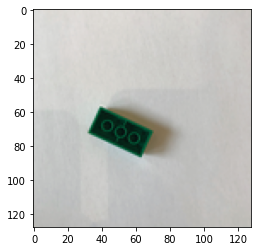

In [12]:
print(y_train[1])
plt.imshow(X_train[1].permute(1, 2, 0))
plt.show()

In [13]:
# create train dataset using X and y train
train_ds = torch.utils.data.TensorDataset(X_train, y_train)
# create train data loader
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

# create val dataset using X and y val
val_ds = torch.utils.data.TensorDataset(X_val, y_val)
# create val data loader
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)

In [14]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 48, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(48, 128, 1)
        self.fc1 = nn.Linear(131072, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

        # Define proportion or neurons to dropout
        self.dropout2d = nn.Dropout2d(0.1)
        self.dropout1d = nn.Dropout(0.1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout2d(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout2d(x)
#         print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
#         print(x.shape)
        x = F.relu(self.fc1(x))
        x = self.dropout1d(x)
        x = F.relu(self.fc2(x))
        x = self.dropout1d(x)
        x = self.fc3(x)
        return x


net = Net()

In [15]:
# Functions for the training and evaluation phase of the model. This is after model setup
def model_train(model, train_loader, optimiser, loss_fn, loss_train, accuracy_train, device = torch.device("cpu")):
    
    model.train() # set into training mode
    loss_epoch = 0 # set cumulative loss to zero
    correct = 0 # set count of correct predictions to zero
    total = 0 # set total datapoints count to zero
   
    for batch in train_loader:        
        model.zero_grad() # initialise gradients to zero
        images, gtruth = batch # set images from batch
        # images = images.to(device)
        # gtruth = gtruth.to(device)
        outputs = model(images) # forward pass: compute predicted outputs by passing inputs through model
        loss = loss_fn(outputs, gtruth) # calculate the loss
        loss.backward() # backpropagate regularised loss
        optimiser.step() # single update of weights
        loss_epoch += loss.item() # update running training loss
        preds = F.log_softmax(outputs, dim = 1) # make predictions using softmax
        y_hat = torch.argmax(preds, dim = 1) 
        correct += torch.sum(y_hat == gtruth)
        total += len(gtruth)    

    loss_train.append(loss_epoch/len(train_loader))
    accuracy_train.append(torch.div(correct,float(total)))


        
def model_eval(model, val_loader, loss_fn, loss_val, accuracy_val, device = torch.device("cpu")):
    
    model.eval() # set to evaluation mode.     
    loss_total = 0
    correct = 0
    total = 0
    
    with torch.no_grad(): # no backpropagation/ weight updates!
        for batch in val_loader:
            images, gtruth = batch
            # images = images.to(device) # send images to device if necessary
            # gtruth = gtruth.to(device) # send gtruth targets to device if necessary
            preds = model(images)
            loss = loss_fn(preds, gtruth)
            loss_total += loss.item() # update running training loss 
            preds = F.log_softmax(preds, dim = 1)
            y_hat = torch.argmax(preds, dim = 1)
            correct += torch.sum(y_hat == gtruth)
            total += len(gtruth)
        
    loss_val.append(loss_total/len(val_loader))
    accuracy_val.append(torch.div(correct,float(total)))

In [ ]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
# sgd with momentum gives poor results with loss not dropping
# optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 
net.train()

loss_train = []
loss_val = []
acc_train = []
acc_val = []

st = time.time()

for epoch in range(50):  # loop over the dataset multiple times

    model_train(net, train_dl, optimizer, criterion, loss_train, acc_train, device = device)
    model_eval(net, val_dl, criterion, loss_val, acc_val, device = device)

    if epoch % 2 == 0:
        print(f'Epoch: {epoch} |Loss (train): {loss_train[-1]:.3f} (val): {loss_val[-1]:.3f} |Acc (train): {acc_train[-1]:.3f} (val): {acc_val[-1]:.3f}')

print('Time taken: {:.2f} seconds'.format(time.time() - st))

Epoch: 0 |Loss (train): 1.602 (val): 1.093 |Acc (train): 0.322 (val): 0.374
Epoch: 2 |Loss (train): 1.102 (val): 1.090 |Acc (train): 0.362 (val): 0.417
Epoch: 4 |Loss (train): 1.084 (val): 1.065 |Acc (train): 0.385 (val): 0.422
Epoch: 6 |Loss (train): 1.031 (val): 1.015 |Acc (train): 0.445 (val): 0.450
Epoch: 8 |Loss (train): 0.974 (val): 0.971 |Acc (train): 0.502 (val): 0.512
Epoch: 10 |Loss (train): 0.937 (val): 1.042 |Acc (train): 0.526 (val): 0.488
Epoch: 12 |Loss (train): 0.885 (val): 0.907 |Acc (train): 0.562 (val): 0.621
Epoch: 14 |Loss (train): 0.828 (val): 0.901 |Acc (train): 0.626 (val): 0.649
Epoch: 16 |Loss (train): 0.792 (val): 1.027 |Acc (train): 0.621 (val): 0.517
Epoch: 18 |Loss (train): 0.776 (val): 0.906 |Acc (train): 0.656 (val): 0.630
Epoch: 20 |Loss (train): 0.692 (val): 0.868 |Acc (train): 0.671 (val): 0.654
Epoch: 22 |Loss (train): 0.632 (val): 0.826 |Acc (train): 0.742 (val): 0.725
Epoch: 24 |Loss (train): 0.518 (val): 0.831 |Acc (train): 0.780 (val): 0.716
Epoc

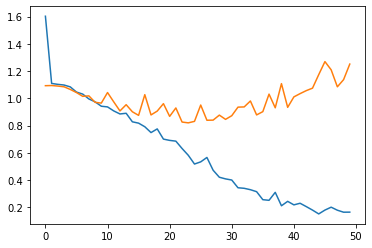

In [ ]:
plt.plot(loss_train)
plt.plot(loss_val)
plt.show()

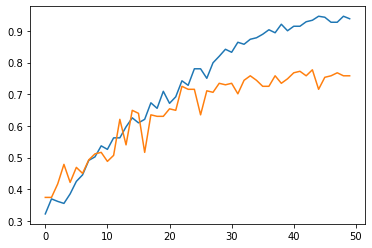

In [ ]:
plt.plot(acc_train)
plt.plot(acc_val)
plt.show()

In [ ]:
model_save_path = './models/cnn_prototype_01.pt'
torch.save({'model_state_dict': net.state_dict(), 
            'optimizer_state_dict': optimizer.state_dict(),
           }, model_save_path)

Re-load pretrained model and predict

In [16]:
# reload pretrained model
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
pretrained_model_path = './models/cnn_prototype_01.pt'
checkpoint = torch.load(pretrained_model_path)
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [17]:
def model_pred(model, val_loader, loss_fn, preds_raw_list, preds_list, yhat_list, gtruth_list, device = torch.device("cpu")):
    
    model.eval() # set to evaluation mode.     
    loss_total = 0
    correct = 0
    total = 0
    
    with torch.no_grad(): # no backpropagation/ weight updates!
        for batch in val_loader:
            images, gtruth = batch
            # images = images.to(device) # send images to device if necessary
            # gtruth = gtruth.to(device) # send gtruth targets to device if necessary
            preds_raw = model(images)
            preds = F.softmax(preds_raw, dim = 1)
            y_hat = torch.argmax(preds, dim = 1)
        
            preds_raw_list.extend(preds_raw)
            preds_list.extend(preds)
            yhat_list.extend(y_hat)
            gtruth_list.extend(gtruth)

    preds_raw_list = [x.tolist() for x in preds_raw_list]
    preds_list = [x.tolist() for x in preds_list]
    yhat_list = [x.item() for x in yhat_list] 
    gtruth_list = [x.item() for x in gtruth_list] 

    return preds_raw_list, preds_list, yhat_list, gtruth_list   

In [18]:
preds_raw_list = []
preds_list = []
yhat_list = []
gtruth_list = []
preds_raw_list, preds_list, yhat_list, gtruth_list  = model_pred(net, val_dl, criterion, preds_raw_list, preds_list, yhat_list, gtruth_list, device = device)
# model_pred(net, val_dl, criterion, preds_list, yhat_list, gtruth_list, device = device)


In [51]:
conmat = confusion_matrix(gtruth_list, yhat_list, labels=[0, 1, 2])
conmat

array([[61,  8,  1],
       [16, 59,  4],
       [11, 11, 40]])

In [25]:
print(pd.DataFrame(conmat, index=['actual 0', 'actual 1', 'actual 2'],
                             columns=['predicted 0', 'predicted 1', 'predicted 2']))

          predicted 0  predicted 1  predicted 2
actual 0           61            8            1
actual 1           16           59            4
actual 2           11           11           40


In [26]:
X_test[0].shape

torch.Size([3, 128, 128])

In [29]:
class_names = ['4x2', '2x2', '3x1']

In [30]:
def vis_images(X_test, fname_list, gtruth_list, yhat_list, preds_list, first_img, nrows, ncols):
    class_names = ['4x2', '2x2', '3x1']
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols+5, nrows+5)) # create figure
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]); # turn off all axes ticks
    idx_plt = 0
    for row in range(nrows):
        for col in range(ncols):
            img = X_test[idx_plt+first_img].permute(1, 2, 0).detach()
            if nrows == 1 or ncols == 1:
                ax[idx_plt].imshow(img)
                ax[idx_plt].set_title(f'gt:{class_names[gtruth_list[idx_plt+first_img]]} pred:{class_names[yhat_list[idx_plt+first_img]]}')
            else:
                ax[row][col].imshow(img)
                ax[row][col].set_title(f'gt:{class_names[gtruth_list[idx_plt+first_img]]} pred:{class_names[yhat_list[idx_plt+first_img]]}')
            idx_plt+= 1
            
    plt.tight_layout()
    plt.show()

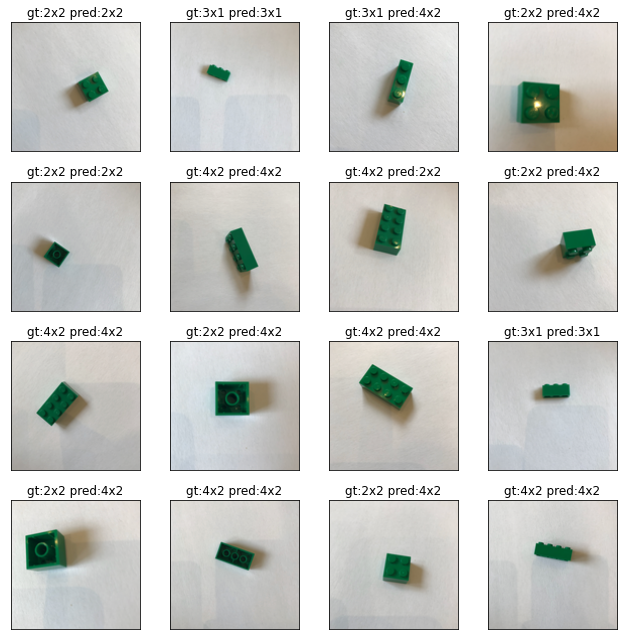

In [45]:
vis_images(X_val, fname_val, gtruth_list, yhat_list, preds_list, first_img=0, nrows=4, ncols=4)

In [39]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img.permute(1, 2, 0).detach(), cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(3))
  plt.yticks([])
  thisplot = plt.bar(class_names, predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

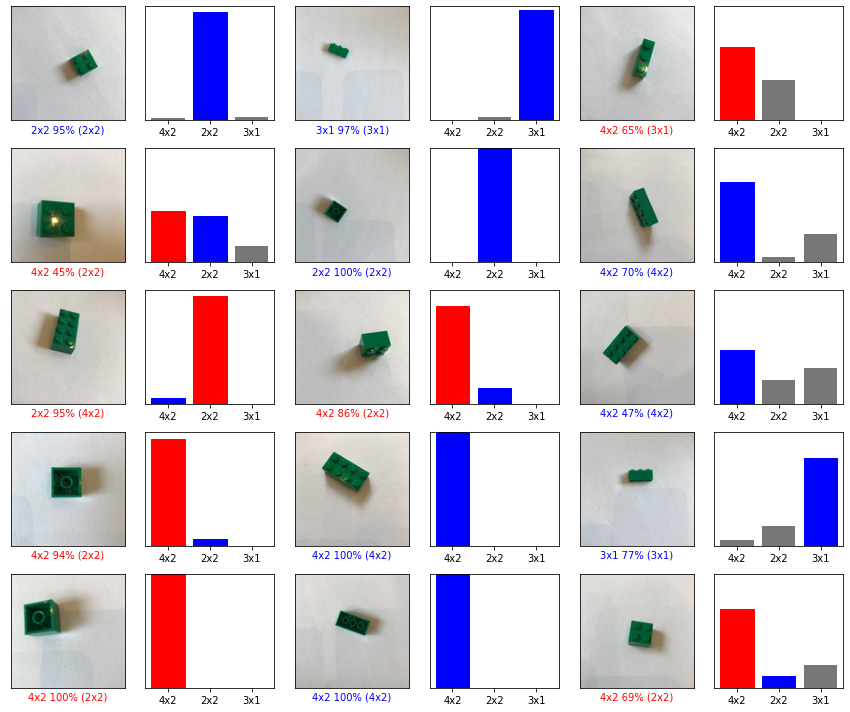

In [48]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, preds_list[i], gtruth_list, X_val)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, preds_list[i], gtruth_list)
plt.tight_layout()
plt.show()

In [49]:
# for i in range(len(gtruth_list)):
#     if gtruth_list[i] != yhat_list[i]:
#         print(gtruth_list[i], yhat_list[i])
#         print(preds_list[i][yhat_list[i]])
#         print(i)

In [50]:
# correct += torch.sum(y_hat == gtruth)